<a href="https://colab.research.google.com/github/EmilEndres/destroytheworld/blob/master/CXR_Classifier(CNP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
!pip install fastai
import warnings
warnings.filterwarnings('ignore')
import PIL
from PIL import ImageFile
!pip install pillow==5.3.0
ImageFile.LOAD_TRUNCATED_IMAGES = True

## **Getting some System Environment info**

In [ ]:
from psutil import *
print('cpu count: ',cpu_count())
print(' ')
print(cpu_stats())
print(' ')
!cat /proc/cpuinfo

cpu count:  2
 
scpustats(ctx_switches=5367347, interrupts=3444865, soft_interrupts=2538482, syscalls=0)
 
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds 

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   36G   33G  53% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   20K  6.4G   1% /var/colab
/dev/sda1        75G   41G   35G  55% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            69G   38G   31G  55% /content/drive


In [ ]:
virtual_memory()

svmem(total=13653602304, available=12694679552, percent=7.0, used=672264192, free=2544300032, active=2534400000, inactive=8015265792, buffers=91914240, cached=10345123840, shared=1032192, slab=419012608)

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [ ]:
!cat /proc/meminfo # the amount of free and used memory on the system and the 
                   # shared memory and buffers used by the kernel

MemTotal:       13333596 kB
MemFree:         2484128 kB
MemAvailable:   12396628 kB
Buffers:           89764 kB
Cached:          9740184 kB
SwapCached:            0 kB
Active:          2475528 kB
Inactive:        7827500 kB
Active(anon):     427064 kB
Inactive(anon):      360 kB
Active(file):    2048464 kB
Inactive(file):  7827140 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               892 kB
Writeback:             0 kB
AnonPages:        473060 kB
Mapped:           237608 kB
Shmem:              1008 kB
Slab:             409288 kB
SReclaimable:     362460 kB
SUnreclaim:        46828 kB
KernelStack:        4768 kB
PageTables:         6296 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666796 kB
Committed_AS:    3323996 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1048 kB
AnonHugePages:   

In [ ]:
!pip list | grep -e fastai -e torch -e torchvision -e matplotlib -e tensorflow -e keras
# verifying that fastai and pytorch are installed and are ready for use

fastai                        1.0.61         
keras-vis                     0.4.1          
matplotlib                    3.2.2          
matplotlib-venn               0.11.6         
tensorflow                    2.4.1          
tensorflow-datasets           4.0.1          
tensorflow-estimator          2.4.0          
tensorflow-gcs-config         2.4.0          
tensorflow-hub                0.11.0         
tensorflow-metadata           0.27.0         
tensorflow-probability        0.12.1         
torch                         1.4.0          
torchsummary                  1.5.1          
torchtext                     0.3.1          
torchvision                   0.5.0          


## Importing fastai and the os library

In [ ]:
import os
from fastai.vision import *
from fastai.metrics import accuracy, error_rate#

### Mount Google storage drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Mapping the training and test paths

In [ ]:
data_root='/content/drive/My Drive/x_ray'

train_data_dir = os.path.join(data_root, 'train')
test_data_dir = os.path.join(data_root, 'test') 

### Specifying the name of the classes

In [ ]:
classes = ['covid19','normal','pneumonia']

### Create an ImageDatabunch that sets the batch size, training and validation distribution, and performs transformations

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder('/content/drive/My Drive/x_ray', train=".", valid_pct=0.2, bs=64,
       ds_tfms=get_transforms(), size=224, num_workers=0).normalize(imagenet_stats)
 # The ImageDataBunch module of the fastai library contains all the necessary functions 
 # to define a Dataset and train a model for computer vision tasks.      

In [ ]:
data.classes

['covid19', 'normal', 'pneumonia']

In [ ]:
data.c

3

### Verifying that the images can be accessed and display 9 sample images

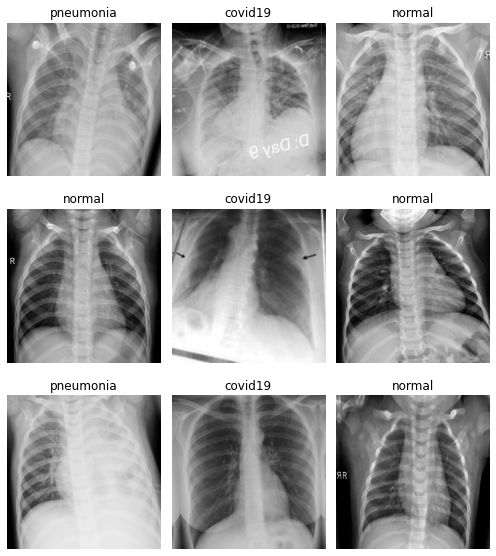

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['covid19', 'normal', 'pneumonia'], 3, 2726, 681)

### Importing the Resnet-50 architecture

In [ ]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet50, metrics=[error_rate,accuracy])

In [ ]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (2726 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/drive/My Drive/x_ray;

Valid: LabelList (681 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,normal,normal,pneumonia,pneumonia
Path: /content/drive/My Drive/x_ray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm

### Force PyTorch to use the GPU

In [ ]:
defaults.device = torch.device('cuda') # use gpu

###Training using the 1cycle approach

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.529795,0.519326,0.116006,0.883994,02:24
1,0.361155,0.156966,0.052863,0.947137,02:21
2,0.260658,0.150898,0.049927,0.950073,02:21
3,0.206234,0.152481,0.052863,0.947137,02:21
4,0.177048,0.147526,0.052863,0.947137,02:21


In [ ]:
learn.save('x_ray_pneumonia_resnet50')

In [ ]:
learn.load('x_ray_pneumonia_resnet50')

Learner(data=ImageDataBunch;

Train: LabelList (2726 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/drive/My Drive/x_ray;

Valid: LabelList (681 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,normal,normal,pneumonia,pneumonia
Path: /content/drive/My Drive/x_ray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [ ]:
learn.unfreeze()

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
___________________________________________________

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


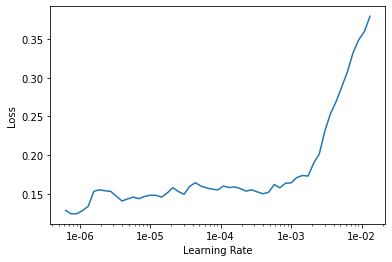

In [ ]:
learn.recorder.plot()

### Find and plot the best individual learning rate

Min numerical gradient: 3.31E-06
Min loss divided by 10: 7.59E-08


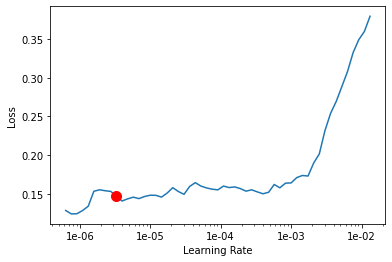

In [ ]:
learn.recorder.plot(suggestion=True)

### Print out the actual best learning rate value

In [ ]:
min_grad_lr = learn.recorder.min_grad_lr
print('scientific:', min_grad_lr)
print('decimal: {0:.10f}'.format(min_grad_lr))

scientific: 3.311311214825911e-06
decimal: 0.0000033113


In [ ]:
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.131482,0.173259,0.051395,0.948605,02:28
1,0.144083,0.186852,0.049927,0.950073,02:27
2,0.125899,0.207866,0.060206,0.939794,02:27
3,0.100749,0.069551,0.019090,0.980910,02:27
4,0.072981,0.111289,0.030837,0.969163,02:26
5,0.060804,0.101226,0.029369,0.970631,02:26


In [ ]:
learn.data.batch_size

64

In [ ]:
preds = learn.pred_batch()
len(preds)

64

In [ ]:
data.classes

['covid19', 'normal', 'pneumonia']

### The first 10 predictions made on the Validation set during training

In [ ]:
preds[:10]

tensor([[1.1030e-05, 1.3834e-06, 9.9999e-01],
        [1.5339e-05, 9.9998e-01, 2.5730e-07],
        [9.7969e-06, 9.9982e-01, 1.7125e-04],
        [1.1164e-07, 6.7801e-06, 9.9999e-01],
        [2.3122e-05, 7.5971e-04, 9.9922e-01],
        [5.2952e-07, 6.4712e-06, 9.9999e-01],
        [5.4327e-07, 7.4541e-04, 9.9925e-01],
        [1.0000e+00, 1.3739e-07, 1.0917e-08],
        [1.1023e-05, 9.9999e-01, 3.0178e-06],
        [9.9928e-01, 7.0201e-06, 7.1491e-04]])

In [ ]:
pip install colored

     |████████████████████████████████| 61kB 5.3MB/s 
  Created wheel for colored: filename=colored-1.4.2-cp36-none-any.whl size=14004 sha256=7b9c1e686e207009c8171c911ae97d3f9bd30834dbda1ae00909b2cae696f3bc
  Stored in directory: /root/.cache/pip/wheels/ec/10/5e/d17d5ef644e1051a753bd98f3796789ec39bc3337cd36637f3
Successfully built colored


In [ ]:
import colored
print(colored.bg("white") + colored.fg("green") + "Hello world!")

Hello world!


In [ ]:
def format_pred(element_in):
  outval = 'normal: {0:.10f}'.format(element_in)
  return outval  
  print(outval)

In [ ]:
n = 1
for element in preds[:10]:
  if element[0] > element[1]:
    vnorm = format_pred(element[0])  
    vnormprt = colored.bg("white") + colored.fg("green") + vnorm
    vpneumprt = format_pred(element[1]) 
    vcovidprt
  elif 
  else:
    vnormprt = format_pred(element[0]) 
    vpneum = format_pred(element[1])  
    vpneumprt = colored.bg("white") + colored.fg("green") + vpneum

  print('Image',str(n), vnormprt, vpneumprt,vcovidprt)
  n += 1

Image 1 normal: 0.0000110300 normal: 0.0000013834
Image 2 normal: 0.0000153386 normal: 0.9999843836
Image 3 normal: 0.0000097969 normal: 0.9998189807
Image 4 normal: 0.0000001116 normal: 0.0000067801
Image 5 normal: 0.0000231223 normal: 0.0007597066
Image 6 normal: 0.0000005295 normal: 0.0000064712
Image 7 normal: 0.0000005433 normal: 0.0007454053
Image 8 normal: 0.9999998808 normal: 0.0000001374
Image 9 normal: 0.0000110234 normal: 0.9999860525
Image 10 normal: 0.9992781281 normal: 0.0000070201


In [ ]:
n = 1
for element in preds[:10]:
  if element[0] > element[1]:
    vnorm = colored.bg("white") + colored.fg("green") + str(element[0])  
    #print(vnorm.)
  elif
  else:
    vpneum = colored.bg("white") + colored.fg("green") + str(element[1])    
  print('Image',str(n),'normal: {0:.10f}'.format(colored.bg("white") + colored.fg("green") + element[0])) #, 'pneumonia: {0:.10f}'.format(vpneum))
  n += 1

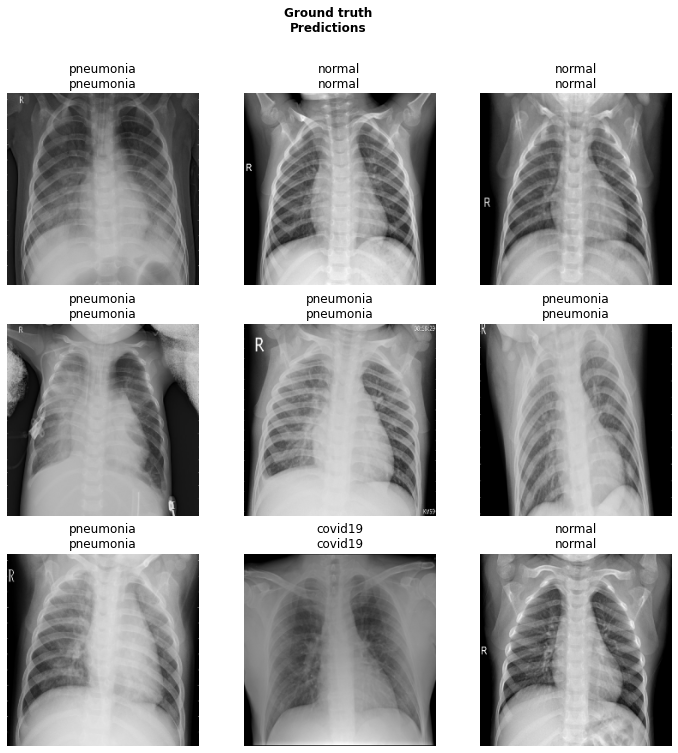

In [ ]:
learn.show_results(rows=3)

### Plot the losses

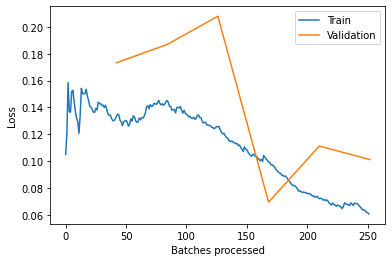

In [ ]:
learn.recorder.plot_losses()

In [ ]:
doc(learn.recorder.plot_losses)

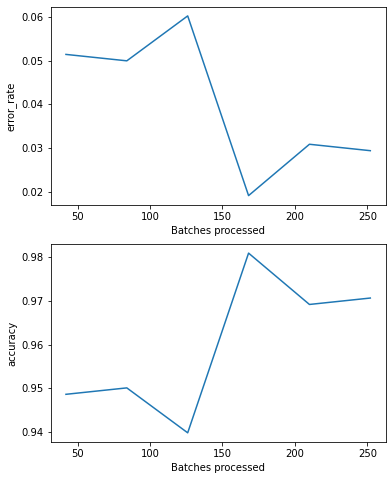

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('x_ray_pneumonia_resnet50_1')

In [ ]:
learn.load('x_ray_pneumonia_resnet50_1')

Learner(data=ImageDataBunch;

Train: LabelList (2726 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/drive/My Drive/x_ray;

Valid: LabelList (681 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,normal,normal,pneumonia,pneumonia
Path: /content/drive/My Drive/x_ray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
___________________________________________________

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.038152,0.089506,0.026432,0.973568,02:28
1,0.044379,0.085676,0.026432,0.973568,02:28
2,0.038769,0.088047,0.024963,0.975037,02:28
3,0.036614,0.079720,0.019090,0.980910,02:28


In [ ]:
learn.save('x_ray_pneumonia_resnet50_final')

In [ ]:
learn.load('x_ray_pneumonia_resnet50_final')

Learner(data=ImageDataBunch;

Train: LabelList (2726 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/drive/My Drive/x_ray;

Valid: LabelList (681 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,normal,normal,pneumonia,pneumonia
Path: /content/drive/My Drive/x_ray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

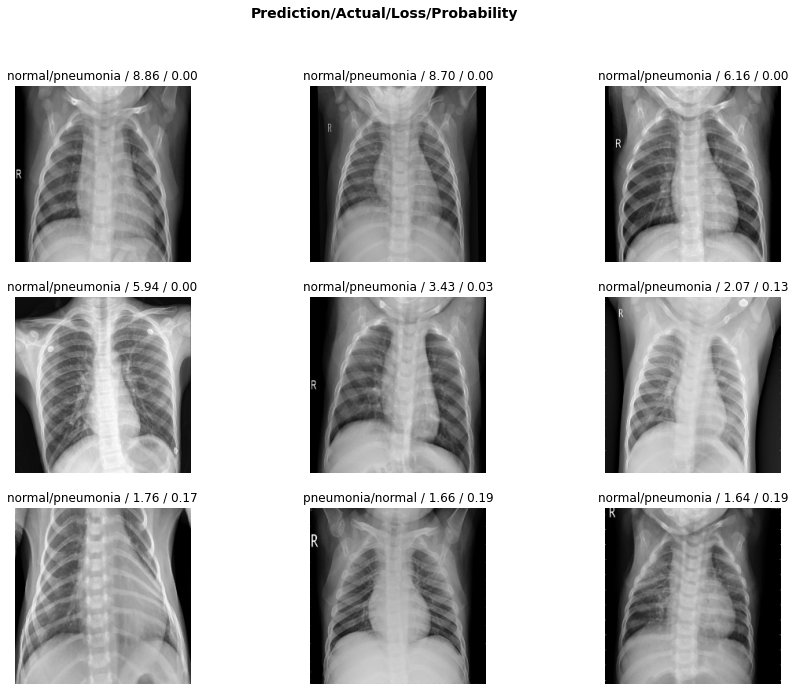

In [ ]:
interp.plot_top_losses(9,figsize=(15,11))

In [ ]:
interp.most_confused(min_val=1)

[('pneumonia', 'normal', 12), ('normal', 'pneumonia', 1)]

In [ ]:
%%html
<img src='https://drive.google.com/uc?id=1WO557kCDKaUhou3TPkDgzoWTiS2NsyS_' width="300 px" height="200 px" />

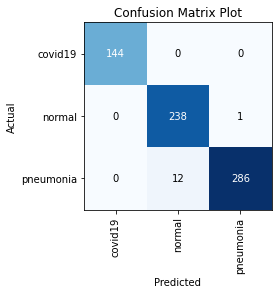

In [ ]:
interp.plot_confusion_matrix(title='Confusion Matrix Plot')

In [ ]:
import pickle

In [ ]:
learn.export()

In [ ]:
learn.export('final_export_Resnet50.pkl')